In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
#  Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, BatchNormalization, Bidirectional, GlobalMaxPool1D
from tensorflow.keras import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import regex
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('wordnet')

seed = 221

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")
train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


### Exploratory Data Analysis

In [5]:
# Check missing values in each column
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [6]:
# Look for the row that has missing values
train[train["text"].isnull()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [7]:
# Check number of labels
print("The number of labels:\n{}".format(train["sentiment"].value_counts()))
print("The proportion of labels:\n{}".format(train["sentiment"].value_counts()/np.sum(train["sentiment"].value_counts())))

The number of labels:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
The proportion of labels:
neutral     0.404570
positive    0.312288
negative    0.283141
Name: sentiment, dtype: float64


### Distribution of tweet text length

<Figure size 576x864 with 0 Axes>

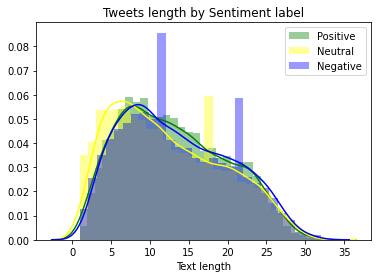

In [19]:
# Visualize the distribution of text length for each sentiment label before preprocessing
plt.figure(figsize = (8, 12))
fig, ax = plt.subplots()
sns.distplot(train[train["sentiment"] == "positive"]["text"].map(lambda x: len(str(x).split())), ax=ax, color = 'green')
sns.distplot(train[train["sentiment"] == "neutral"]["text"].map(lambda x: len(str(x).split())), ax=ax, color = 'yellow')
sns.distplot(train[train["sentiment"] == "negative"]["text"].map(lambda x: len(str(x).split())), ax=ax, color = 'blue')
plt.title('Tweets length by Sentiment label')
plt.xlabel("Text length")
plt.legend(['Positive','Neutral','Negative'])

In [0]:
# Instantiate the lemmmatizer
lemmatizer = WordNetLemmatizer()

def textpreprocess(tweet):
  """
  preprocess the text data for plotting word cloud and one-gram/bi-gram word count.

  """
  # Converts sentence into strings 
  tweet = str(tweet)
  # Converts them into lower case
  tweet = tweet.lower()
  # Removes any html related tags
  tweet = tweet.replace('{html}',"") 
  # Removes expressions with . * ?
  cleanr = re.compile('<.*?>')
  tweet = re.sub(cleanr, '', tweet)
  # Removes http related text
  tweet = re.sub(r'http\S+', '', tweet)
  # Remove numbers
  tweet = re.sub('[0-9]+', '', tweet)
  # Converts sentences into tokens 
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(tweet)
  # Removes stop words  
  filtered_tweet = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  # getting the base form of the words
  filtered_tweet = [lemmatizer.lemmatize(w) for w in filtered_tweet]
  return " ".join(filtered_tweet)

In [0]:
def getWordCloud(tweets, sentiment):
  # Join all tweets into one corpus
  corpus = " ".join(str(tweet) for tweet in tweets)
  # Configure word cloud setup
  wordcloud = WordCloud(
      background_color='white',
      max_words=300,
      max_font_size=40, 
      scale=3,
      random_state=seed 
    ).generate(corpus)
  
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.title('WordCloud - ' + sentiment)
  plt.show()     

### Word cloud for three different sentiments

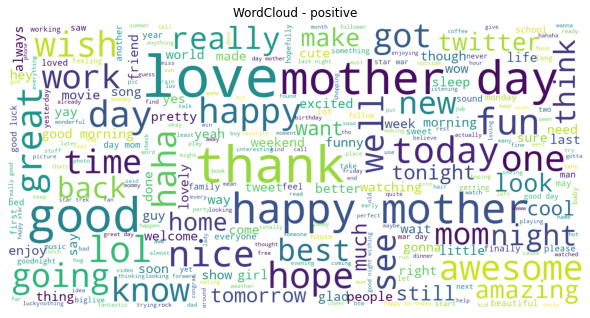

In [11]:
# preprocess the text in the training data that has positive sentiemnt
positivetext = train[train["sentiment"]=="positive"]["text"].map(lambda x: textpreprocess(x))
# Print the wordcloud
getWordCloud(positivetext, "positive", )

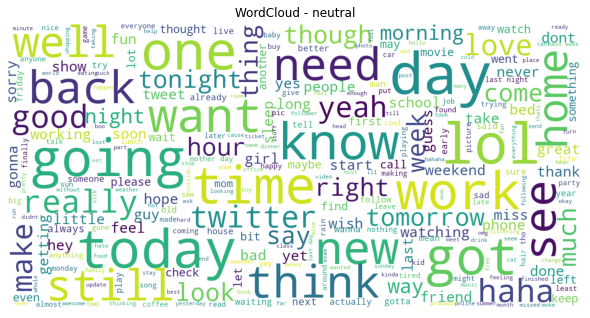

In [12]:
# preprocess the text in the training data that has neutral sentiemnt
neutraltext = train[train["sentiment"]=="neutral"]["text"].map(lambda x: textpreprocess(x))
# Print the wordcloud
getWordCloud(neutraltext, "neutral")

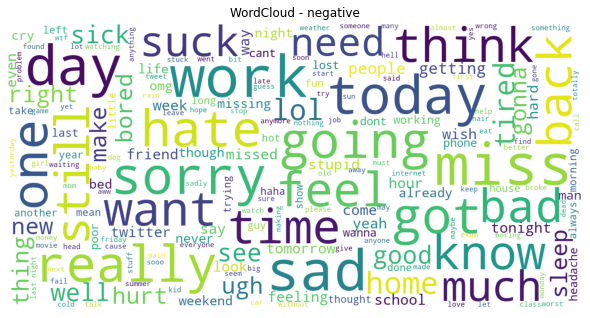

In [13]:
# preprocess the text in the training data that has negative sentiemnt
negativetext =  train[train["sentiment"]=="negative"]["text"].map(lambda x: textpreprocess(x))
# Print the wordcloud
getWordCloud(negativetext, "negative")

### Top Bigrams based on frequency

In [0]:
def getTopBigram(data):
  """
    extract bigram from the tweet in the dataframe
  """
  bigrams = pd.DataFrame()
  # Loop through each tweet
  for index in range(0,len(data)):
    # Split the tweet into strings and get bi-gram in order. Convert it to datafram with 2 columns. 
    #First column is the first word, second columns is the second word
    bigram = pd.DataFrame(nltk.bigrams(data['text'][index].split()))
    # Keep appending to the same dataframe for the tweets
    bigrams = pd.concat([bigrams,bigram])

  # Join the string across columns
  bigrams['combined'] = bigrams.apply(lambda x: ' '.join(x), axis = 1) 
  # Count bigrams and reset index
  bigrams_count = pd.DataFrame(bigrams['combined'].value_counts()).reset_index()
  return bigrams_count

Text(0.5, 1.0, 'Top 30 positive bigram')

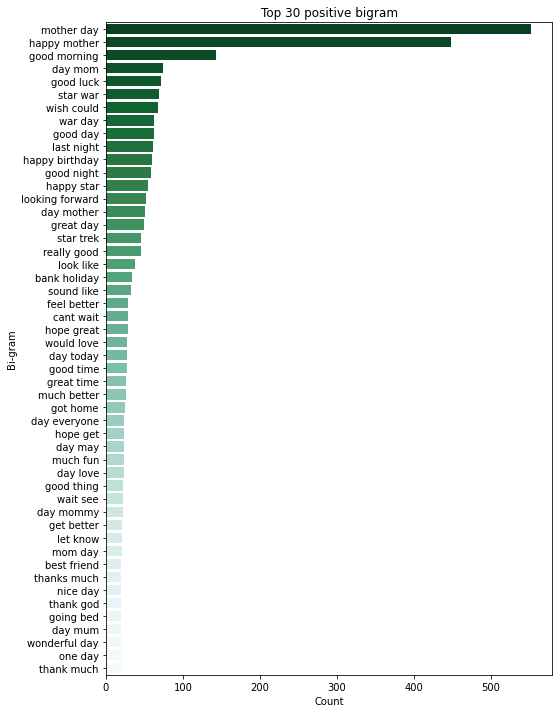

In [15]:
# Get the bigram and its count for positive tweets
pos_count = getTopBigram(positivetext.reset_index())
# Plot a horizontal bar plot
plt.figure(figsize = (8, 12))
ax = sns.barplot(x='combined', y='index', data=pos_count.iloc[0:50,:], palette="BuGn_r")
ax.set_xlabel('Count')
ax.set_ylabel('Bi-gram')
ax.set_title("Top 30 positive bigram")

Text(0.5, 1.0, 'Top 30 negative bigram')

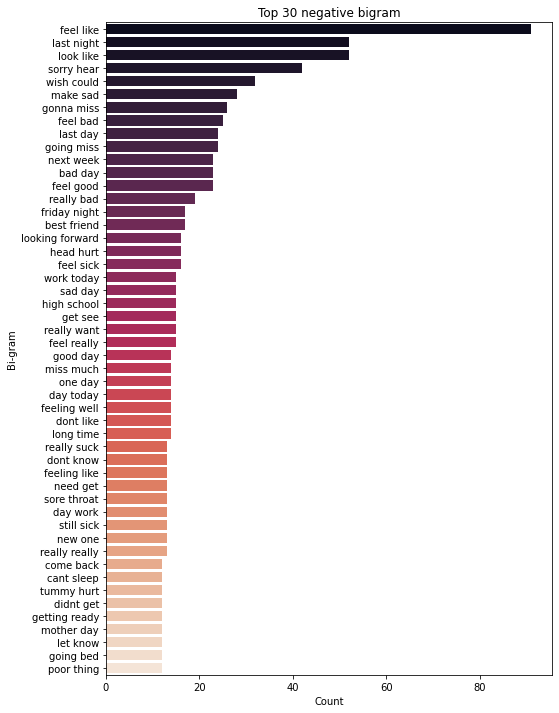

In [16]:
# Get the bigram and its count for negative tweets
neg_count = getTopBigram(negativetext.reset_index())
# Plot a horizontal bar plot
plt.figure(figsize = (8, 12))
ax = sns.barplot(x='combined', y='index', data=neg_count.iloc[0:50,:], palette="rocket")
ax.set_xlabel('Count')
ax.set_ylabel('Bi-gram')
ax.set_title("Top 30 negative bigram")